## Running Facebook Prophet model for forecasting SSB data via Statbank API

Facebook has open sourced [`Prophet`](https://facebookincubator.github.io/prophet/), a forecasting project available in `Python` and `R`.

At its core, the `Prophet` procedure is an **additive regression model** with four main components (based on [`Stan`](http://mc-stan.org) Bayesian approach):
1. a piecewise linear (or logistic) growth curve trend: `Prophet` automatically detects changes in trends by selecting changepoints from the data,
2. a yearly seasonal component modeled using Fourier series,
3. a weekly seasonal component using dummy variables,
4. a user-provided list of important holidays.

We (**make no assumption whatsoever here**, beyond the obvious seasonality of the data) use the features 1. and 2. of the model to **build forecast estimates of Statistics Norway timeseries using [*PX-API*](https://www.ssb.no/en/omssb/tjenester-og-verktoy/api/px-api) **:

<img src="">

We suppose here that all required packages have been already install (see `Prophet` original webpage for `Prophet`'s dependencies). Let us first import everything we need:

In [1]:
import pandas as pd
import numpy as np
# needed for display in notebook:
%matplotlib notebook 
from matplotlib import pyplot as plt
import APIdata as apid

import warnings
warnings.filterwarnings('ignore')


## Testing datasets from API:

In [2]:
statbank = apid.API_to_data(language='en')
statbank.search('macro*')

,table_title,score,published
table_id,,,
09190,Final expenditure and gross domestic product....,0.288675,2018-08-23T08:00:00
09189,Final expenditure and gross domestic product ...,0.288675,2018-08-23T08:00:00
08801,"External trade in goods, by commodity number ...",0.288675,2018-05-15T08:00:00
11009,"External trade in goods, by commodity number ...",0.288675,2018-05-15T08:00:00
11721,Final expenditure and gross domestic product....,0.288675,2018-10-09T08:00:00
11008,"External trade in goods, by commodity number ...",0.288675,2018-10-15T08:00:00
08799,"External trade in goods, by commodity number ...",0.288675,2018-10-15T08:00:00


Select table_id from the list above, and type between ' '

In [4]:
statbank = apid.API_to_data(language='en')
tablenr = '09190'   #måned eksempel: 11721, uke eksempel: 03024, kvartal eksempel: 09190, år eksempel 05803
box_info = statbank.select(tablenr)
box_info

Info is saved. You can now run the rest of the code :)


Run next cell when info is saved.

In [5]:
[df, label] = statbank.read_box(box_info)
df

,macroeconomic indicator,contents,quarter,value
0,"Gross domestic product, market values",Constant 2016-prices (NOK million),1978K1,288553
1,"Gross domestic product, market values",Constant 2016-prices (NOK million),1978K2,297876
2,"Gross domestic product, market values",Constant 2016-prices (NOK million),1978K3,298582
3,"Gross domestic product, market values",Constant 2016-prices (NOK million),1978K4,312749
4,"Gross domestic product, market values",Constant 2016-prices (NOK million),1979K1,304271
5,"Gross domestic product, market values",Constant 2016-prices (NOK million),1979K2,294970
6,"Gross domestic product, market values",Constant 2016-prices (NOK million),1979K3,315293
7,"Gross domestic product, market values",Constant 2016-prices (NOK million),1979K4,335598
8,"Gross domestic product, market values",Constant 2016-prices (NOK million),1980K1,335169
9,"Gross domestic product, market values",Constant 2016-prices (NOK million),1980K2,321009


The table contains exactly the data we need, let us store it into a `pandas.DataFrame` object as desired. As already mentioned, the input to `Prophet` is always a `pandas.DataFrame` object, and it must contain two columns: `ds` and `y`. 

In [6]:
[df, f, periods] = statbank.prepare_dataframe(df=df)
df.head()

,ds,y
0,1978-03-31 00:00:00,288553
1,1978-06-30 00:00:00,297876
2,1978-09-30 00:00:00,298582
3,1978-12-31 00:00:00,312749
4,1979-03-31 00:00:00,304271


In [7]:
type(df)

pandas.core.frame.DataFrame

<IPython.core.display.Javascript object>


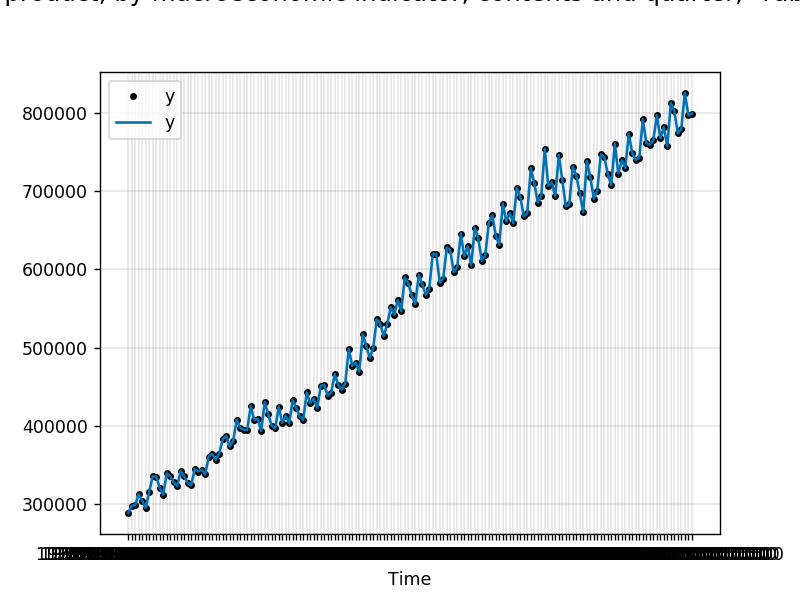

In [8]:
df.sort_values('ds', inplace=True)
ds_last = df['ds'].values[-1]
xlabel = "Time"
ylabel = "Value"  
plt.plot(df['ds'], df['y'], 'k.')
plt.plot(df['ds'], df['y'], ls='-', c='#0072B2')
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.xlabel(xlabel, fontsize=10); #plt.ylabel(ylabel, fontsize=10)
plt.suptitle(" {},  Table: {}  (last: {})".format(label, tablenr, ds_last), fontsize=14, y=1.03)
plt.legend()
plt.show()

Considering the trend observed in the data, we define the regression model for `Prophet` by instantiating a new `Prophet` model as follows:

Growth can be set to 'linear' eller 'logistic'. 
Possible to add parameter: seasonality_mode: 'additive' (default) or 'multiplicative'.
Possible to set Markov chain Monte Carlo (MCMC), e.g. mcmc_samples=300

In [17]:
from fbprophet import Prophet
nyears=4
m = Prophet(growth = 'linear', weekly_seasonality=False, yearly_seasonality=True, daily_seasonality=False)  

We then call its `fit` method and pass in the historical dataframe built earlier:

We extend the data into the future by a specified number periods using the `make_future_dataframe` method. Say that we consider to predict the time-series over the 4 next years:

In [18]:
m.fit(df)
future = m.make_future_dataframe(periods=periods*nyears, freq=f)
fcst = m.predict(future)

Let us plot the forecast estimates calculated by the `Prophet` model:

<IPython.core.display.Javascript object>


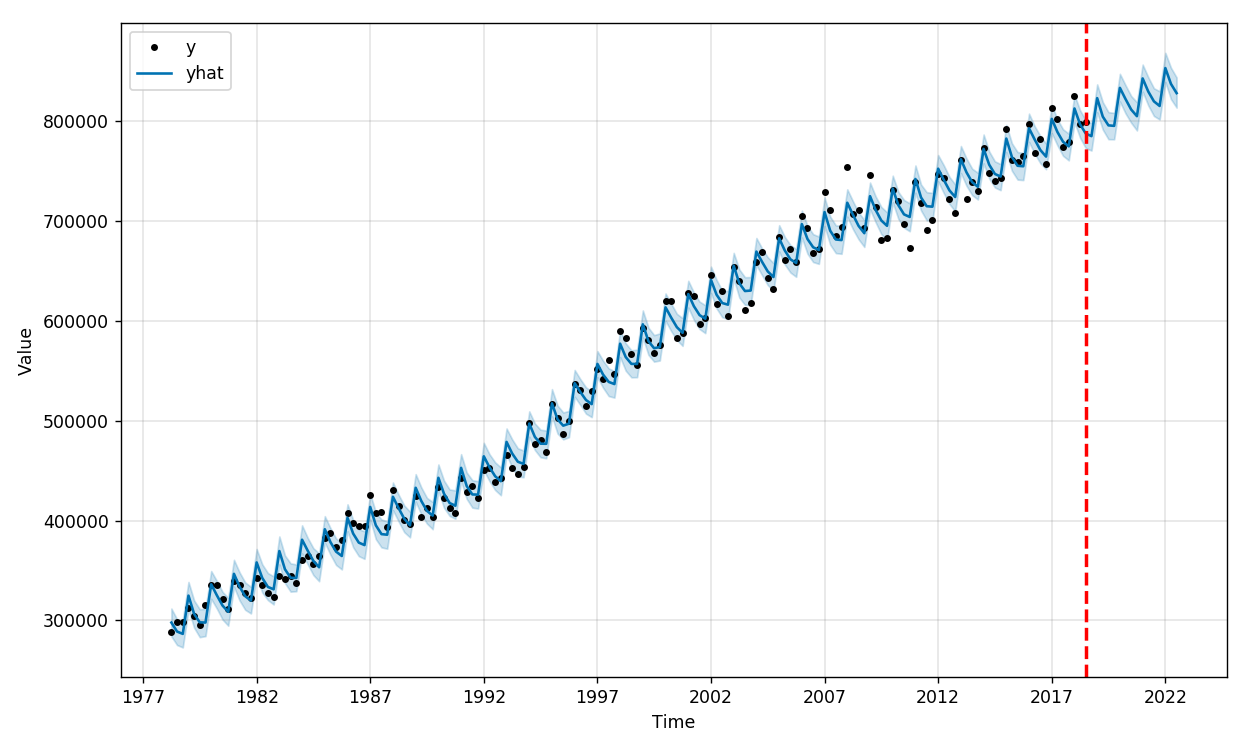

In [19]:
m.plot(fcst, uncertainty=True)
xlabel = "Time"
ylabel = "Value" 
plt.axvline(pd.to_datetime(ds_last), color='r', linestyle='--', lw=2)
plt.xlabel(xlabel, fontsize=10); plt.ylabel(ylabel, fontsize=10)
plt.suptitle(" {} {} forecast data ({} years)".format(tablenr, label, nyears), fontsize=14, y=1.05)
plt.legend()
plt.show()
plt.savefig("{}_{}y.svg".format(tablenr, nyears))

`Prophet` also provides with the components (overall trend and yearly profile) of the time-series:

<IPython.core.display.Javascript object>


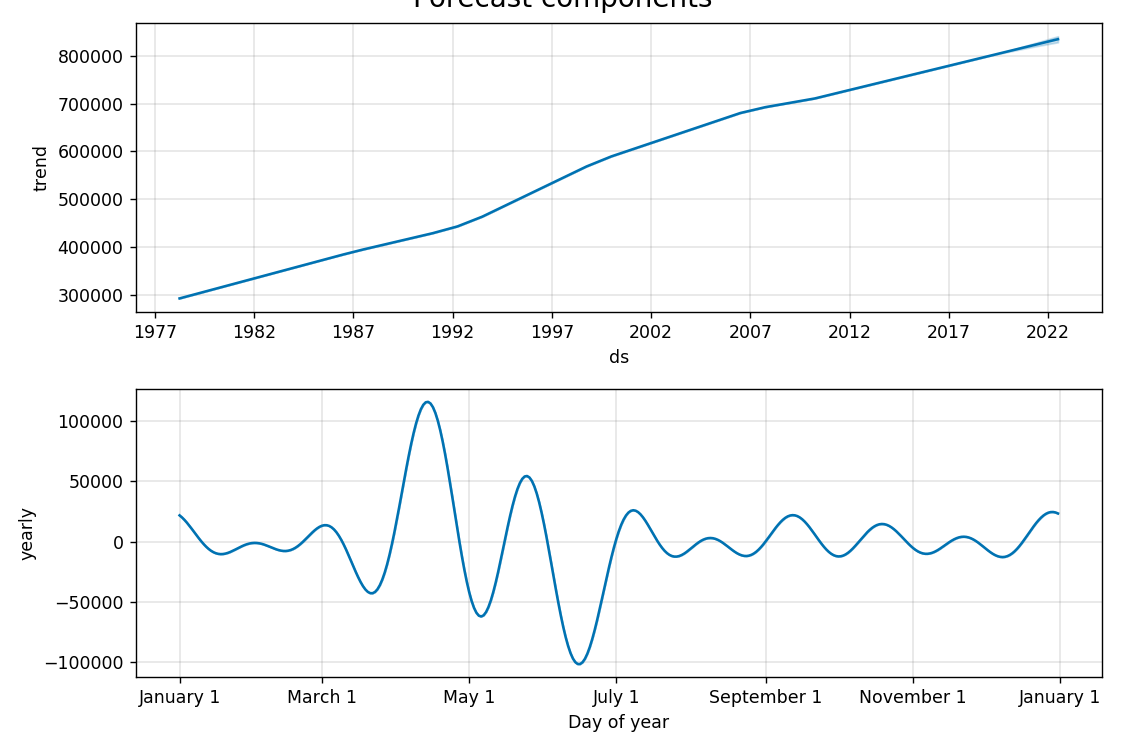

In [20]:
fig = m.plot_components(fcst, uncertainty=True)
fig.suptitle("Forecast components", fontsize=16, y=1.02)
plt.show()

In [21]:
result = pd.concat([fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], df['y']], axis=1)
result

,ds,yhat,yhat_lower,yhat_upper,y
0,1978-03-31,297799.388366,283973.099896,311825.895879,288553.0
1,1978-06-30,288814.765373,275343.569680,301154.311174,297876.0
2,1978-09-30,286475.546573,272909.865703,300676.926300,298582.0
3,1978-12-31,324767.323160,311081.245215,338444.371196,312749.0
4,1979-03-31,306517.747012,292687.398510,319976.945461,304271.0
5,1979-06-30,298040.360887,283189.014303,311196.527936,294970.0
6,1979-09-30,297804.147999,284249.169285,311507.544517,315293.0
7,1979-12-31,336138.976605,321540.599595,349356.776652,335598.0
8,1980-03-31,325128.711360,311857.601846,339481.829313,335169.0
9,1980-06-30,314877.768208,300895.812966,328553.504207,321009.0


In [22]:
result.tail()

,ds,yhat,yhat_lower,yhat_upper,y
173,2021-06-30,819738.085867,805107.887199,832852.873784,NaN
174,2021-09-30,815102.778044,801579.583012,829839.320035,NaN
175,2021-12-31,853034.921188,839077.479352,868287.451897,NaN
176,2022-03-31,837207.590375,821965.547120,853374.091133,NaN
177,2022-06-30,827962.909390,813437.331796,843624.221733,NaN


In [23]:
result.to_csv("{}_{}y.csv".format(tablenr, nyears), sep = ';', decimal = ',')

In [16]:
result.to_excel("{}_{}y.xlsx".format(tablenr, nyears))

C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:819: DeprecationWarning: invalid escape sequence \w
  if re.match('\w:', url) or re.match(r'\\', url):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:947: DeprecationWarning: invalid escape sequence \s
  if re.search('^\s', token) or re.search('\s$', token):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:947: DeprecationWarning: invalid escape sequence \s
  if re.search('^\s', token) or re.search('\s$', token):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:3723: DeprecationWarning: invalid escape sequence \|
  elif re.match('(or|\|\|)', conditional):
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:3953: DeprecationWarning: invalid escape sequence \.
  name = re.sub('\..*$', '', name)
C:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:5382: DeprecationWarning: invalid escape sequence \s
  if re.search('^\s', string) or re.sear

**-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**